# Step 3.1: Exploratory Data Analysis (FIXED)

**FIXES:**
- Correct save paths (../../docs/ instead of docs/)
- Skip assists model (all values are 0)
- Everything else unchanged

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
print("✓ Imports complete")

✓ Imports complete


In [2]:
# Load data
engine = create_engine('postgresql://medhanshchoubey@localhost:5432/football_props')

query = """
    SELECT 
        pf.*,
        p.position
    FROM player_features pf
    JOIN players p ON pf.player_id = p.player_id
    WHERE pf.minutes_played > 0
    ORDER BY pf.match_date
"""

df = pd.read_sql(query, engine)

# Create binary targets
df['has_goal'] = (df['goals'] > 0).astype(int)
df['has_assist'] = (df['assists'] > 0).astype(int)
df['shots_over_2.5'] = (df['shots_on_target'] > 2.5).astype(int)
df['has_card'] = ((df['yellow_cards'] + df['red_cards']) > 0).astype(int)

print(f"Loaded: {len(df)} records")
print(f"Date range: {df['match_date'].min()} to {df['match_date'].max()}")
print(f"Positions: {df['position'].value_counts().to_dict()}")
print(f"\nBinary prop rates:")
print(f"  Goals: {df['has_goal'].mean():.1%}")
print(f"  Assists: {df['has_assist'].mean():.1%}")
print(f"  Shots>2.5: {df['shots_over_2.5'].mean():.1%}")
print(f"  Cards: {df['has_card'].mean():.1%}")

Loaded: 1720 records
Date range: 2018-06-14 to 2018-07-15
Positions: {'Forward': 628, 'Defender': 512, 'Midfielder': 463, 'Goalkeeper': 117}

Binary prop rates:
  Goals: 8.2%
  Assists: 0.0%
  Shots>2.5: 1.0%
  Cards: 9.5%


## Part 1: Distribution Analysis

✓ Saved: ../../docs/01_distributions.png


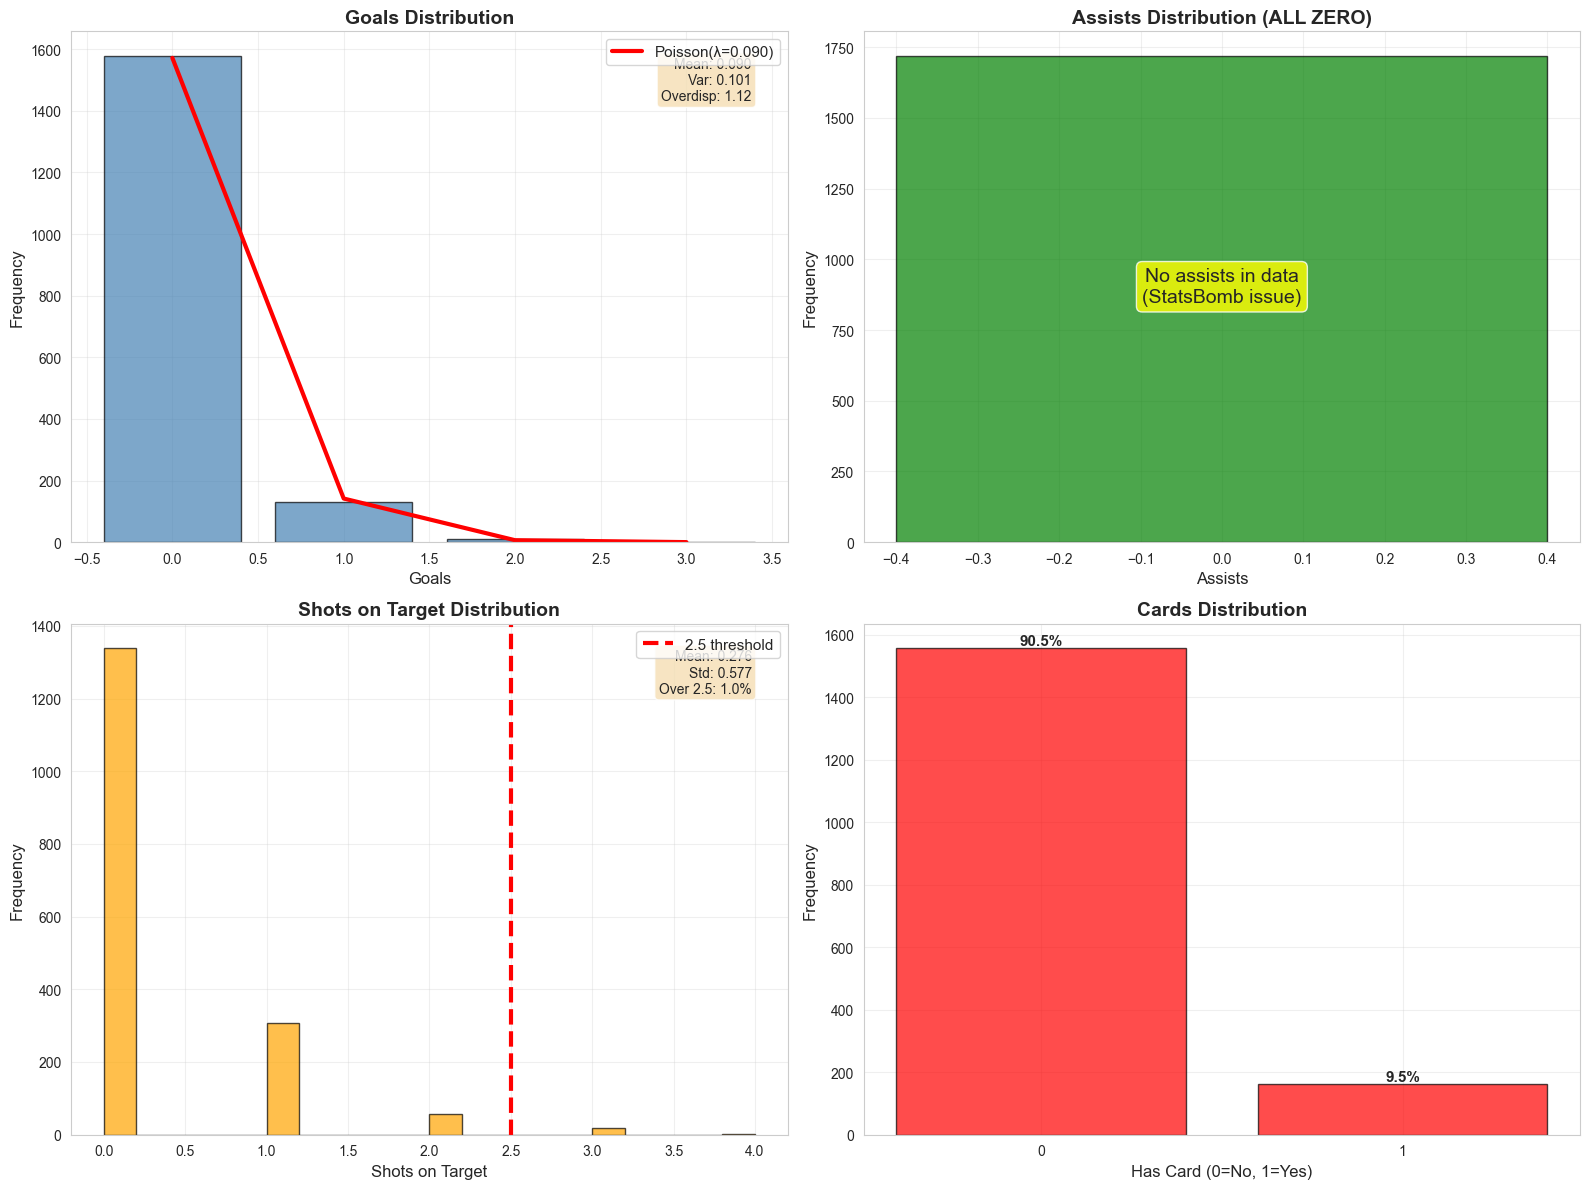

In [3]:
# Overall distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Goals
ax = axes[0, 0]
goals_counts = df['goals'].value_counts().sort_index()
ax.bar(goals_counts.index, goals_counts.values, alpha=0.7, edgecolor='black', color='steelblue')
lambda_goals = df['goals'].mean()
x = np.arange(0, goals_counts.index.max() + 1)
poisson_fit = stats.poisson.pmf(x, lambda_goals) * len(df)
ax.plot(x, poisson_fit, 'r-', linewidth=3, label=f'Poisson(λ={lambda_goals:.3f})')
ax.set_xlabel('Goals', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Goals Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
overdispersion = df['goals'].var() / df['goals'].mean()
text = f"Mean: {df['goals'].mean():.3f}\nVar: {df['goals'].var():.3f}\nOverdisp: {overdispersion:.2f}"
ax.text(0.95, 0.95, text, transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)

# Assists
ax = axes[0, 1]
assists_counts = df['assists'].value_counts().sort_index()
ax.bar(assists_counts.index, assists_counts.values, alpha=0.7, edgecolor='black', color='green')
ax.set_xlabel('Assists', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Assists Distribution (ALL ZERO)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.text(0.5, 0.5, 'No assists in data\n(StatsBomb issue)', 
        transform=ax.transAxes, ha='center', va='center', fontsize=14, 
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# Shots
ax = axes[1, 0]
ax.hist(df['shots_on_target'], bins=20, alpha=0.7, edgecolor='black', color='orange')
ax.axvline(2.5, color='red', linestyle='--', linewidth=3, label='2.5 threshold')
ax.set_xlabel('Shots on Target', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Shots on Target Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
text = f"Mean: {df['shots_on_target'].mean():.3f}\nStd: {df['shots_on_target'].std():.3f}\nOver 2.5: {df['shots_over_2.5'].mean():.1%}"
ax.text(0.95, 0.95, text, transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)

# Cards
ax = axes[1, 1]
cards_counts = df['has_card'].value_counts().sort_index()
bars = ax.bar(cards_counts.index, cards_counts.values, alpha=0.7, edgecolor='black', color='red')
ax.set_xlabel('Has Card (0=No, 1=Yes)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Cards Distribution', fontsize=14, fontweight='bold')
ax.set_xticks([0, 1])
ax.grid(alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = height / len(df) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../../docs/01_distributions.png', dpi=150, bbox_inches='tight')  # FIXED PATH
print("✓ Saved: ../../docs/01_distributions.png")
plt.show()

In [4]:
# Statistical summary
print("="*70)
print("STATISTICAL SUMMARY")
print("="*70)

for prop, name in [('goals', 'GOALS'), ('shots_on_target', 'SHOTS'), ('has_card', 'CARDS')]:
    print(f"\n{name}:")
    print(f"  Mean: {df[prop].mean():.4f}")
    print(f"  Std: {df[prop].std():.4f}")
    print(f"  Min: {df[prop].min():.0f}")
    print(f"  Max: {df[prop].max():.0f}")
    
    if prop != 'has_card':
        var = df[prop].var()
        mean = df[prop].mean()
        if mean > 0:
            overdispersion = var / mean
            print(f"  Variance: {var:.4f}")
            print(f"  Overdispersion (Var/Mean): {overdispersion:.4f}")
            if overdispersion > 1.5:
                print(f"  → OVERDISPERSED - consider Negative Binomial")
            else:
                print(f"  → Poisson is reasonable")

STATISTICAL SUMMARY

GOALS:
  Mean: 0.0901
  Std: 0.3173
  Min: 0
  Max: 3
  Variance: 0.1007
  Overdispersion (Var/Mean): 1.1170
  → Poisson is reasonable

SHOTS:
  Mean: 0.2762
  Std: 0.5768
  Min: 0
  Max: 4
  Variance: 0.3326
  Overdispersion (Var/Mean): 1.2045
  → Poisson is reasonable

CARDS:
  Mean: 0.0948
  Std: 0.2930
  Min: 0
  Max: 1


## Part 2: Position-Specific Analysis

✓ Saved: ../../docs/02_position_distributions.png


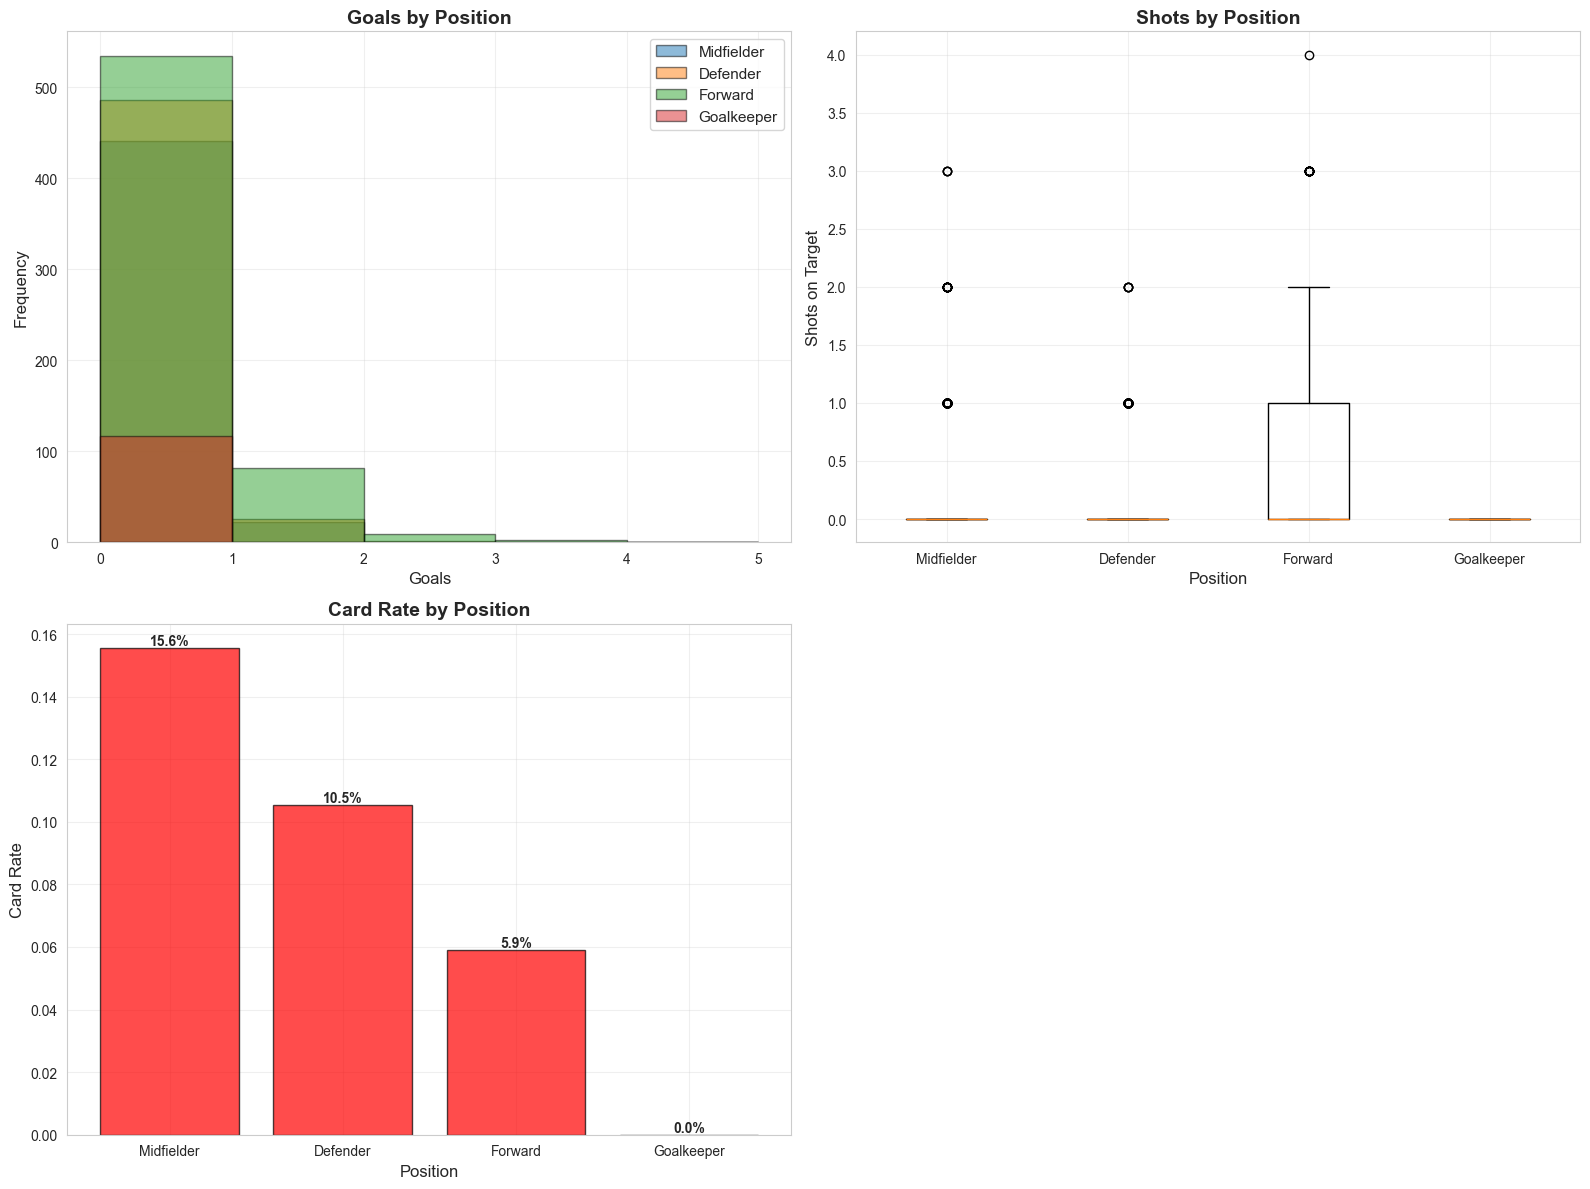

In [5]:
# Distribution by position
positions = df['position'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Goals by position
ax = axes[0, 0]
for pos in positions:
    pos_df = df[df['position'] == pos]
    ax.hist(pos_df['goals'], bins=range(6), alpha=0.5, label=pos, edgecolor='black')
ax.set_xlabel('Goals', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Goals by Position', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Shots by position
ax = axes[0, 1]
position_shots = [df[df['position'] == pos]['shots_on_target'].values for pos in positions]
ax.boxplot(position_shots, labels=positions)
ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Shots on Target', fontsize=12)
ax.set_title('Shots by Position', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Cards by position
ax = axes[1, 0]
card_rates = [df[df['position'] == pos]['has_card'].mean() for pos in positions]
bars = ax.bar(positions, card_rates, alpha=0.7, edgecolor='black', color='red')
ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Card Rate', fontsize=12)
ax.set_title('Card Rate by Position', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, card_rates)):
    ax.text(bar.get_x() + bar.get_width()/2., val,
            f'{val:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Hide 4th subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('../../docs/02_position_distributions.png', dpi=150, bbox_inches='tight')  # FIXED PATH
print("✓ Saved: ../../docs/02_position_distributions.png")
plt.show()

In [6]:
# Position statistics
print("="*70)
print("STATISTICS BY POSITION")
print("="*70)

for pos in positions:
    pos_df = df[df['position'] == pos]
    print(f"\n{pos} (n={len(pos_df)}):")
    print(f"  Goals: {pos_df['goals'].mean():.3f} ± {pos_df['goals'].std():.3f}")
    print(f"  Shots: {pos_df['shots_on_target'].mean():.3f} ± {pos_df['shots_on_target'].std():.3f}")
    print(f"  Card rate: {pos_df['has_card'].mean():.1%}")

STATISTICS BY POSITION

Midfielder (n=463):
  Goals: 0.048 ± 0.213
  Shots: 0.212 ± 0.512
  Card rate: 15.6%

Defender (n=512):
  Goals: 0.053 ± 0.232
  Shots: 0.143 ± 0.372
  Card rate: 10.5%

Forward (n=628):
  Goals: 0.169 ± 0.434
  Shots: 0.484 ± 0.729
  Card rate: 5.9%

Goalkeeper (n=117):
  Goals: 0.000 ± 0.000
  Shots: 0.000 ± 0.000
  Card rate: 0.0%


## Part 3: Correlation Analysis

✓ Saved: ../../docs/03_correlations.png


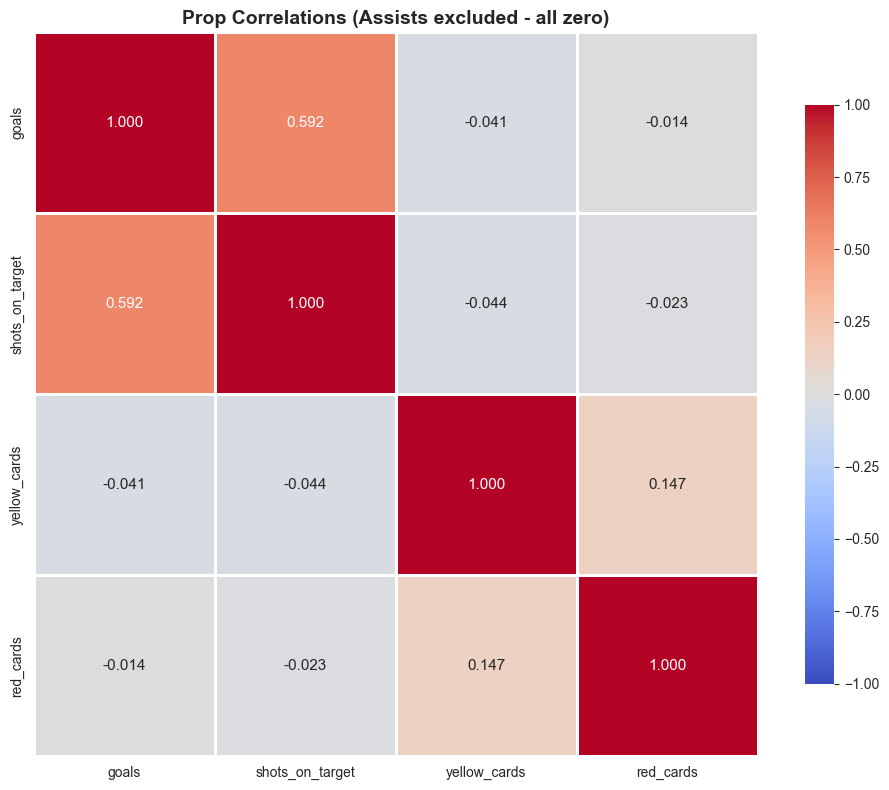

In [7]:
# Correlation matrix (skip assists - all zeros)
props = ['goals', 'shots_on_target', 'yellow_cards', 'red_cards']
corr_matrix = df[props].corr()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            ax=ax, vmin=-1, vmax=1, annot_kws={'fontsize': 11})
ax.set_title('Prop Correlations (Assists excluded - all zero)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../../docs/03_correlations.png', dpi=150, bbox_inches='tight')  # FIXED PATH
print("✓ Saved: ../../docs/03_correlations.png")
plt.show()

In [8]:
# Key correlations
print("="*70)
print("KEY CORRELATIONS")
print("="*70)
print(f"\nGoals vs Shots: {corr_matrix.loc['goals', 'shots_on_target']:.3f}")
print(f"Goals vs Yellow Cards: {corr_matrix.loc['goals', 'yellow_cards']:.3f}")

print(f"\nImplications for modeling:")
if corr_matrix.loc['goals', 'shots_on_target'] > 0.3:
    print("  ✓ High goals-shots correlation → multi-task learning will help")
if abs(corr_matrix.loc['goals', 'yellow_cards']) < 0.2:
    print("  ✓ Low goals-cards correlation → can model independently")

KEY CORRELATIONS

Goals vs Shots: 0.592
Goals vs Yellow Cards: -0.041

Implications for modeling:
  ✓ High goals-shots correlation → multi-task learning will help
  ✓ Low goals-cards correlation → can model independently


## Part 4: Baseline Models (Skip Assists)

In [9]:
# Helper function for ECE
def expected_calibration_error(y_true, y_prob, n_bins=10):
    """Calculate Expected Calibration Error."""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

In [10]:
# Prepare features
feature_cols = ['goals_rolling_5', 'shots_on_target_rolling_5', 'opponent_strength', 
                'days_since_last_match', 'was_home']
X = df[feature_cols].fillna(df[feature_cols].mean())
X['was_home'] = X['was_home'].astype(int)

# Time-based split (80/20)
split_idx = int(len(df) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")

Train: 1376 samples
Test: 344 samples


In [11]:
# Train baseline models (SKIP ASSISTS)
results = {}

for target, target_name in [('has_goal', 'Goals'),
                             ('shots_over_2.5', 'Shots>2.5'),
                             ('has_card', 'Cards')]:
    
    y_train = df[target].iloc[:split_idx]
    y_test = df[target].iloc[split_idx:]
    
    # Check if we have both classes
    if len(y_train.unique()) < 2:
        print(f"⚠️  Skipping {target_name} - only one class in training data")
        continue
    
    # Train
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    
    # Predict
    y_pred_proba = lr.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    brier = brier_score_loss(y_test, y_pred_proba)
    ece = expected_calibration_error(y_test.values, y_pred_proba)
    
    results[target] = {
        'name': target_name,
        'model': lr,
        'y_test': y_test,
        'y_pred_proba': y_pred_proba,
        'acc': acc,
        'auc': auc,
        'brier': brier,
        'ece': ece
    }

# Print results
print("="*70)
print("BASELINE MODEL RESULTS")
print("="*70)
print(f"\n{'Prop':<15} {'Accuracy':<12} {'AUC':<10} {'Brier':<10} {'ECE':<10}")
print("-"*70)
for target, res in results.items():
    print(f"{res['name']:<15} {res['acc']:<12.3f} {res['auc']:<10.3f} {res['brier']:<10.3f} {res['ece']:<10.4f}")

print(f"\nTarget for Bayesian model: ECE < 0.05")
print(f"Baseline average ECE: {np.mean([r['ece'] for r in results.values()]):.4f}")

BASELINE MODEL RESULTS

Prop            Accuracy     AUC        Brier      ECE       
----------------------------------------------------------------------
Goals           0.904        0.600      0.087      0.0482    
Shots>2.5       0.991        0.612      0.008      0.0025    
Cards           0.898        0.443      0.092      0.0168    

Target for Bayesian model: ECE < 0.05
Baseline average ECE: 0.0225


✓ Saved: ../../docs/04_baseline_calibration_goals.png


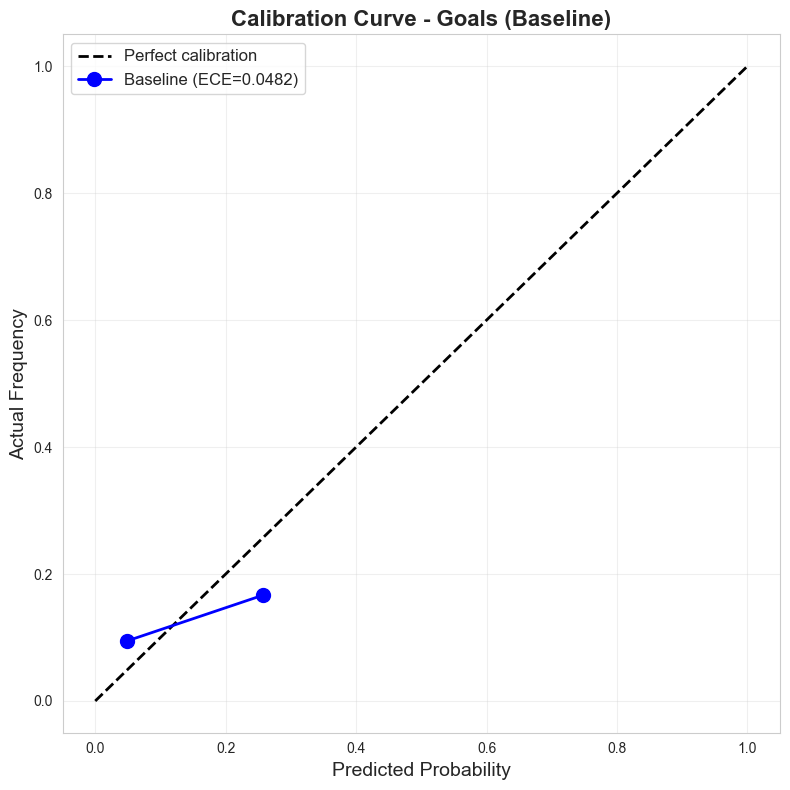

In [12]:
# Calibration curve for goals
if 'has_goal' in results:
    res = results['has_goal']
    prob_true, prob_pred = calibration_curve(res['y_test'], res['y_pred_proba'], n_bins=5)
    
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')
    plt.plot(prob_pred, prob_true, 'o-', markersize=10, linewidth=2,
             label=f'Baseline (ECE={res["ece"]:.4f})', color='blue')
    plt.xlabel('Predicted Probability', fontsize=14)
    plt.ylabel('Actual Frequency', fontsize=14)
    plt.title('Calibration Curve - Goals (Baseline)', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('../../docs/04_baseline_calibration_goals.png', dpi=150, bbox_inches='tight')  # FIXED PATH
    print("✓ Saved: ../../docs/04_baseline_calibration_goals.png")
    plt.show()
else:
    print("⚠️  Skipping calibration plot - no goals model")

✓ Saved: ../../docs/05_baseline_calibration_all.png


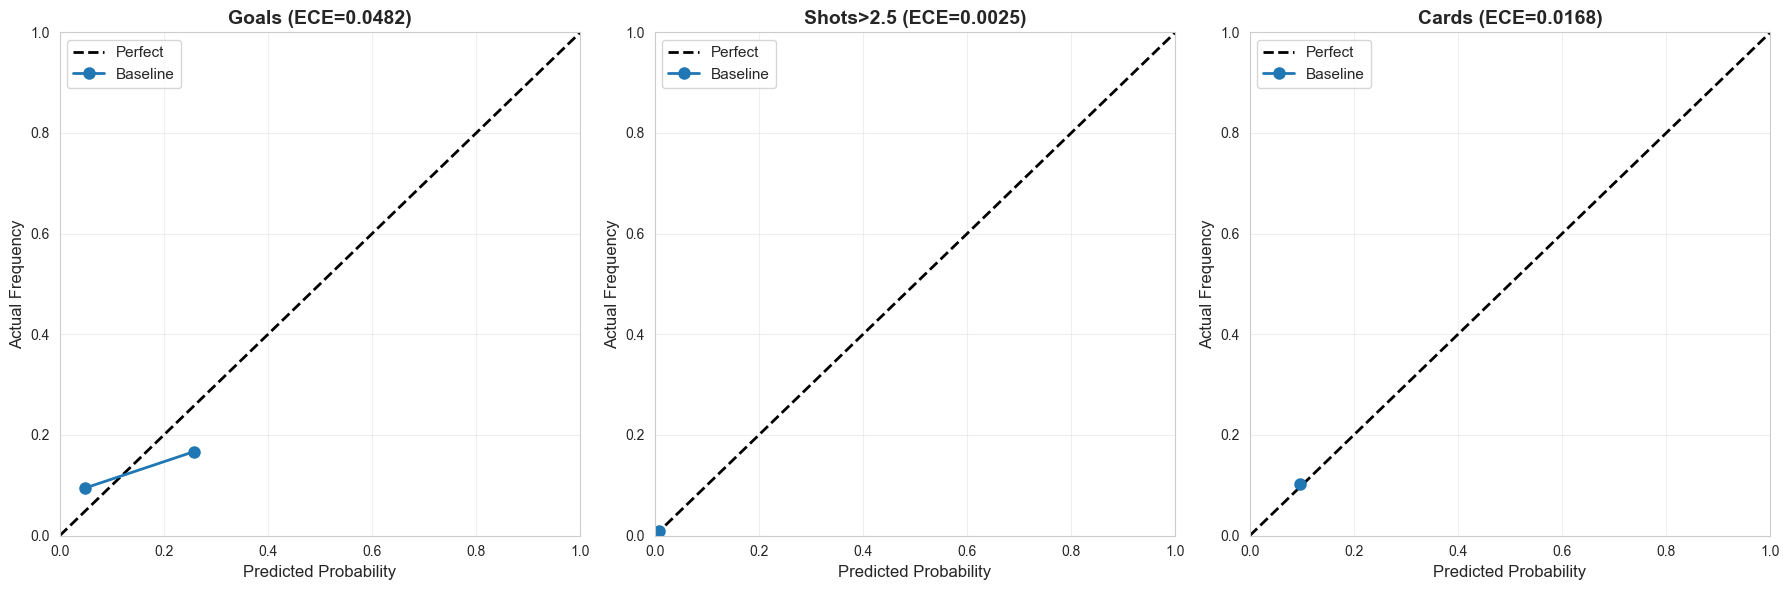

In [13]:
# All calibration curves
n_models = len(results)
if n_models > 0:
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 6))
    if n_models == 1:
        axes = [axes]
    
    for idx, (target, res) in enumerate(results.items()):
        ax = axes[idx]
        prob_true, prob_pred = calibration_curve(res['y_test'], res['y_pred_proba'], n_bins=5)
        
        ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect')
        ax.plot(prob_pred, prob_true, 'o-', markersize=8, linewidth=2, label='Baseline')
        
        ax.set_xlabel('Predicted Probability', fontsize=12)
        ax.set_ylabel('Actual Frequency', fontsize=12)
        ax.set_title(f'{res["name"]} (ECE={res["ece"]:.4f})', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(alpha=0.3)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('../../docs/05_baseline_calibration_all.png', dpi=150, bbox_inches='tight')  # FIXED PATH
    print("✓ Saved: ../../docs/05_baseline_calibration_all.png")
    plt.show()
else:
    print("⚠️  No models to plot")

In [14]:
# Feature importance for goals
if 'has_goal' in results:
    lr_goals = results['has_goal']['model']
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': lr_goals.coef_[0]
    }).sort_values('coefficient', ascending=False)
    
    print("="*70)
    print("FEATURE IMPORTANCE (Goals Model)")
    print("="*70)
    print(feature_importance.to_string(index=False))
    print("\nInterpretation:")
    print("  Positive → increases P(goal)")
    print("  Negative → decreases P(goal)")

FEATURE IMPORTANCE (Goals Model)
                  feature  coefficient
shots_on_target_rolling_5     0.860956
          goals_rolling_5     0.147866
                 was_home    -0.220918
    days_since_last_match    -0.328245
        opponent_strength    -1.057898

Interpretation:
  Positive → increases P(goal)
  Negative → decreases P(goal)


## Summary & Next Steps

In [15]:
# Final summary
print("\n" + "="*70)
print("STEP 3.1 COMPLETE - EDA SUMMARY")
print("="*70)

print("\n✓ Files created:")
for i in range(1, 6):
    print(f"  - docs/0{i}_*.png")

print("\n✓ Key findings:")
print(f"  - Goals: λ={df['goals'].mean():.3f} (Poisson prior)")
print(f"  - Assists: SKIP (all zeros in data)")
print(f"  - Shots: μ={df['shots_on_target'].mean():.3f}, σ={df['shots_on_target'].std():.3f}")
print(f"  - Cards: p={df['has_card'].mean():.3f} (Bernoulli prior)")
print(f"  - Goals-Shots correlation: {corr_matrix.loc['goals', 'shots_on_target']:.3f}")
if len(results) > 0:
    print(f"  - Average baseline ECE: {np.mean([r['ece'] for r in results.values()]):.4f}")

print("\n✓ Recommendations for Bayesian model:")
if df['goals'].var() / df['goals'].mean() > 1.5:
    print("  - Consider Negative Binomial (overdispersed)")
else:
    print("  - Poisson is good for goals")
print("  - SKIP assists (no variation)")
print("  - Use hierarchical priors by position")
print("  - Multi-task for correlated props (goals + shots)")
print("  - Include home advantage")

print("\n" + "="*70)
print("NEXT: Tell me 'Step 3.1 done - ready for 3.2'")
print("="*70)


STEP 3.1 COMPLETE - EDA SUMMARY

✓ Files created:
  - docs/01_*.png
  - docs/02_*.png
  - docs/03_*.png
  - docs/04_*.png
  - docs/05_*.png

✓ Key findings:
  - Goals: λ=0.090 (Poisson prior)
  - Assists: SKIP (all zeros in data)
  - Shots: μ=0.276, σ=0.577
  - Cards: p=0.095 (Bernoulli prior)
  - Goals-Shots correlation: 0.592
  - Average baseline ECE: 0.0225

✓ Recommendations for Bayesian model:
  - Poisson is good for goals
  - SKIP assists (no variation)
  - Use hierarchical priors by position
  - Multi-task for correlated props (goals + shots)
  - Include home advantage

NEXT: Tell me 'Step 3.1 done - ready for 3.2'
